# Exoplanet Candidate Scoring App

This notebook provides a lightweight interface for loading a saved model, scoring new exoplanet candidates, and reviewing the top predictions.

Use this as a quick front end on top of the pipeline artifacts in `artifacts/` and the feature configuration in `configs/`.


In [26]:
# Core imports
import pathlib
import json
import pandas as pd
import numpy as np
import joblib
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook")

# Paths relative to this notebook
ROOT = pathlib.Path("..")
CONFIG_PATH = ROOT / "configs" / "train.yaml"
MODEL_PATH = ROOT / "artifacts" / "models" / "model_xgboost.joblib"
SAMPLE_PATH = ROOT / "data" / "raw" / "pscomppars_sample.csv"

## Load configuration and model

We load the feature list from the training config and reload the XGBoost model saved in `artifacts/models`.  
The feature order must match the configuration used during training.

In [27]:
# Load feature configuration
with CONFIG_PATH.open("r") as f:
    cfg = yaml.safe_load(f)

feature_cols = cfg["features"]["include"]

# Load trained model
model = joblib.load(MODEL_PATH)

feature_cols

['pl_orbper',
 'pl_rade',
 'st_teff',
 'st_rad',
 'sy_snum',
 'sy_pnum',
 'disc_year',
 'discoverymethod']

## Define helper functions

Small utilities to select model features and compute prediction probabilities.  
These keep the scoring logic simple and consistent with the training pipeline.

In [28]:
# Functions for preparing and scoring candidates
def prepare_candidates(df, feature_cols):
    """Select and order feature columns used by the model."""
    return df[feature_cols]

def score_candidates(df, feature_cols, model):
    """Return a copy of df with prediction probabilities."""
    X = prepare_candidates(df, feature_cols)
    proba = model.predict_proba(X)[:, 1]  # probability of confirmed class
    out = df.copy()
    out["pred_confirmed_proba"] = proba
    return out

## Load candidate table

For now, we use the bundled `pscomppars_sample.csv`. To score a new table, point `input_path` to your own CSV with the same schema.

In [29]:
# Use the sample candidate table by default
input_path = SAMPLE_PATH

df_raw = pd.read_csv(input_path)
df_raw.head()

,pl_name,pl_orbper,pl_rade,st_teff,st_rad,sy_snum,sy_pnum,disc_year,discoverymethod,target_confirmed
0,3204.01,4.044654,2.440000,5172.70,0.95000,1.0,1.0,2016.0,Transit,0
1,6700.01,15.517754,9.482582,6314.93,1.49694,1.0,1.0,2016.0,Transit,0
2,Kepler-431 b,6.802522,0.970000,6293.00,1.68200,1.0,3.0,2015.0,Transit,1
3,3954.01,3.404315,20.356800,5833.00,1.00000,1.0,1.0,2016.0,Transit,0
4,1795.01,2.791791,6.000207,6071.00,1.16271,1.0,1.0,2016.0,Transit,0


## Score candidates

Apply the trained model to compute the predicted probability that each candidate is a confirmed exoplanet.

In [30]:
scored = score_candidates(df_raw, feature_cols, model)

# Sort by highest predicted probability
scored_sorted = scored.sort_values("pred_confirmed_proba", ascending=False)

scored_sorted[["pl_name"] + feature_cols + ["pred_confirmed_proba"]].head(10)

,pl_name,pl_orbper,pl_rade,st_teff,st_rad,sy_snum,sy_pnum,disc_year,discoverymethod,pred_confirmed_proba
6730,HD 38529 b,14.32,2.44,5370.00,2.820000,2.0,2.0,2000.0,Radial Velocity,1.0
6107,HD 177830 b,407.37,2.44,4744.94,3.576443,2.0,2.0,1999.0,Radial Velocity,1.0
5461,75 Cet c,2051.62,2.44,4809.00,10.380000,2.0,2.0,2023.0,Radial Velocity,1.0
391,gam Lib b,414.88,2.44,4879.00,12.380000,1.0,2.0,2018.0,Radial Velocity,1.0
10285,HD 87816 b,484.17,2.44,4989.00,9.000000,1.0,2.0,2025.0,Radial Velocity,1.0
7540,HD 177830 c,110.90,2.44,4949.00,2.620000,2.0,2.0,2010.0,Radial Velocity,1.0
6168,HD 4732 b,360.20,2.44,4959.00,5.400000,2.0,2.0,2012.0,Radial Velocity,1.0
1348,Kepler-432 c,406.20,2.44,4995.00,4.060000,2.0,2.0,2015.0,Radial Velocity,1.0
8825,HD 184010 c,484.30,2.44,4971.00,4.860000,1.0,3.0,2022.0,Radial Velocity,1.0
3023,HD 184010 b,286.60,2.44,4971.00,4.860000,1.0,3.0,2022.0,Radial Velocity,1.0


## Probability distribution

A quick look at the model’s confidence levels across all candidates in the input table.

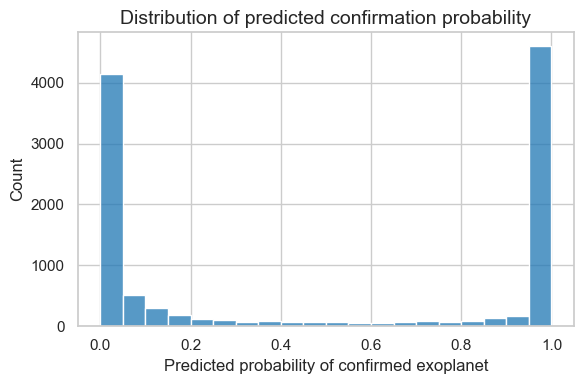

In [31]:
plt.figure(figsize=(6, 4))
sns.histplot(scored_sorted["pred_confirmed_proba"], bins=20, kde=False)
plt.title("Distribution of predicted confirmation probability", fontsize=14)
plt.xlabel("Predicted probability of confirmed exoplanet", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

**Interpretation**

This distribution shows that the model is very confident for most candidates.
Two strong peaks appear:

Near 0.0 — many candidates receive extremely low confirmation probabilities, meaning the model is confident they are not confirmed exoplanets.

Near 1.0 — a smaller but clear group receives very high probabilities, indicating strong model confidence in likely confirmations.

The long, sparse middle range (0.1 to 0.9) suggests the model rarely produces uncertain scores. This behavior is typical of well-separated classes and is consistent with the strong performance seen in calibration and precision–recall results.

## Export results

Save the scored output to `artifacts/scored_candidates.csv` for later analysis or reporting.

In [32]:
output_path = ROOT / "artifacts" / "scored_candidates.csv"
scored_sorted.to_csv(output_path, index=False)

output_path

PosixPath('../artifacts/scored_candidates.csv')

## Summary

This notebook provides a minimal interface for fast scoring.  
The workflow: load config → load model → load table → score → export.

This keeps the scoring step reproducible and aligned with the main training pipeline.